<a href="https://colab.research.google.com/github/croco22/CapstoneProjectTDS/blob/main/notebooks/04_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extra Task 2: Dashboard
An interactive dashboard built as a Gradio app for testing the answering of questionnaires in a user-friendly way. Responses are processed in the background using Hugging Face models to provide relevant insights and evaluations. Additionally, a Speech-To-Text model has been integrated, allowing users to answer questions verbally, which are then automatically transcribed into text.

The secrets `GOOGLE_API_KEY` and `HF_TOKEN` must be configured in your Colab environment for proper execution.

## Imports and Setup

In [1]:
%%capture
!pip install qrcode[pil]
!pip install SpeechRecognition
!pip install gradio
!pip install dateparser
# !pip install git+https://github.com/openai/whisper.git

import io
import os
import re
import sys
import time
from datetime import datetime

import dateparser
import pytz
import qrcode
import requests
import speech_recognition as sr
import gradio as gr
import pandas as pd
from IPython.display import display, Image
from google.colab import userdata
import google.generativeai as genai
from transformers import pipeline
# import whisper
# from sentence_transformers import SentenceTransformer
# from sklearn.metrics.pairwise import cosine_similarity

In [2]:
recognizer = sr.Recognizer()
timezone = pytz.timezone('Europe/Berlin')

# API Setup
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
model = genai.GenerativeModel('gemini-2.0-flash-exp')
userdata.get('HF_TOKEN') # optional

# Download favicon
image_url = "https://raw.githubusercontent.com/croco22/CapstoneProjectTDS/refs/heads/main/images/croco.jpg"
img_data = requests.get(image_url).content
with open('favicon.png', 'wb') as handler:
    handler.write(img_data)


def generate_text(prompt):
    """
    Generates text based on the provided prompt using the genai model. The function sends the prompt
    to the model, with a generation configuration that includes a temperature of 2.0 for creative output.
    It then waits for 5 seconds to avoid exceeding API limits before returning the generated text.
    """
    try:
        response = model.generate_content(
            prompt,
            generation_config=genai.GenerationConfig(
                temperature=2.0, # creative output
            )
        )
        time.sleep(10) # avoid exceeding API limits
        return response.text.strip()
    except Exception as e:
        exit("Error during API call: ", e)

## Load the data from the provided questionnaires

In [3]:
dfs = list()

for q in range(1, 6):
    url = f'https://raw.githubusercontent.com/croco22/CapstoneProjectTDS/refs/heads/main/questionnaires/questionnaire{q}.json'
    temp_df = pd.read_json(url)

    # Unpack options into an array
    temp_df['options'] = temp_df['options'].apply(lambda x: [option['option'] for option in x])

    # Remove options for specific question types
    temp_df.loc[temp_df['type'].isin(['TEXT', 'NUMBER', 'DATE']), 'options'] = None

    # Include the name of the questionnaire
    temp_df['questionnaire'] = f"Questionnaire {q}"

    dfs.append(temp_df)

df = pd.concat(dfs, ignore_index=True)

## Rephrase Questions
The reason for rephrasing the questions is that some questions in the questionnaire may consist of only single words or are not structured as proper questions. By rephrasing them, we ensure that the questions are clear, complete, and easy for the user to understand.

**Warning**: This cell may take a few minutes to execute as it calls the Gemini API a few times.

In [4]:
def rephrase_question(text):
    prompt = f"""
        Reformulate the following statement into a clear, concise, and
        grammatically correct question that directly addresses the user. For
        example, 'Do you consent to data processing?' or 'What kind of follow-up
        would you prefer?'. If the text is already a question, preserve its
        meaning and intent without altering the content or facts. The statement
        is: '{text}'. Return only the reformulated question, without any
        additional explanations, comments, or text.
    """
    return generate_text(prompt)


df['rephrased_question'] = df['question'].apply(rephrase_question)

df = df[['questionnaire', 'type', 'rephrased_question', 'options']].copy()
df['answer'] = "<skipped by user>"
df['missed_count'] = 0

df.head()

,questionnaire,type,rephrased_question,options,answer,missed_count
0,Questionnaire 1,SINGLE_SELECT,Do you consent to data processing?,"[Yes, No]",<skipped by user>,0
1,Questionnaire 1,SINGLE_SELECT,What is your customer group?,"[End User, Wholesaler, Distributor, Consultant...",<skipped by user>,0
2,Questionnaire 1,MULTI_SELECT,Which products are you interested in?,"[MY-SYSTEM, Notion, JTS, JS EcoLine, AKW100, A...",<skipped by user>,0
3,Questionnaire 1,MULTI_SELECT,What kind of follow-up is planned?,"[Email, Phone, Schedule a Visit, No action]",<skipped by user>,0
4,Questionnaire 1,MULTI_SELECT,Who should be copied on the follow up?,"[Stephan Maier, Joachim Wagner, Erik Schneider...",<skipped by user>,0


## Evaluate Context

### Cosine Similarity (no longer in use)
The code evaluates the relevance of questions and answers based on their similarity to a given context or message. It computes scores for each question or answer by combining the results from a Q&A model with cosine similarity between embeddings. The most relevant question or answer is selected based on the highest combined score, ensuring that the response aligns closely with the provided context or query. This approach leverages both semantic understanding and contextual relevance to improve the selection process.

After extensive testing, we decided to use **Zero-Shot Classification** in our final submission because it delivered the best results.

In [5]:
# qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# def evaluate_context(context, unanswered_questions):
#     best_question = None
#     highest_score = -1
#     context_embedding = embedding_model.encode([context])

#     for question in unanswered_questions:
#         qa_result = qa_pipeline(question=question, context=context)
#         score = qa_result['score']

#         question_embedding = embedding_model.encode([question])
#         similarity = cosine_similarity(context_embedding, question_embedding)[0][0]

#         combined_score = score * similarity

#         if combined_score > highest_score:
#             highest_score = combined_score
#             best_question = question

#     return best_question

# def evaluate_answer(message, options):
#     message_embedding = embedding_model.encode([message])

#     highest_similarity = -1
#     best_answer = None

#     for option in options:
#         option_embedding = embedding_model.encode([option])
#         similarity = cosine_similarity([message_embedding[0]], [option_embedding[0]])[0][0]

#         if similarity > highest_similarity:
#             highest_similarity = similarity
#             best_answer = option

#     return best_answer

### Zero-Shot Classification
The code evaluates a given context against a list of potential questions or answer types based on the specified question type. It uses a Zero-Shot classification model (such as BART or DeBERTa) to match the context to the most relevant question:

- For **single select questions** (`SINGLE_SELECT`), it identifies the most relevant question based on the highest classification score.
- For **multi-select questions** (`MULTI_SELECT`), it returns all questions with a classification score above a threshold (0.25).
- For **text-based questions** (`TEXT`), it simply returns the context itself.
- For **numeric questions** (`NUMBER`), it processes the context to extract a number.
- For **date-related questions** (`DATE`), it processes the context to extract a date.

If none of these categories match, it returns an error message indicating that evaluation is not possible.

In [6]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

def evaluate_context(context, questions, qtype=None, real_question=None):
    if qtype is None or qtype == "SINGLE_SELECT":
        question_results = classifier(context, candidate_labels=questions)
        best_match = question_results["labels"][0]
        return best_match
    elif qtype == "MULTI_SELECT":
        question_results = classifier(context, candidate_labels=questions, multi_label=True)
        best_matches = [
            label for label, score in zip(question_results["labels"], question_results["scores"])
            if score > 0.25 # threshold was determined empirically after testing different values
        ]
        # Ensure at least one answer is selected
        if not best_matches:
            best_matches = [question_results["labels"][0]]
        return ", ".join(map(str, best_matches))
    elif qtype == "TEXT":
        return context
    elif qtype == "NUMBER":
        result = qa_pipeline(question=real_question, context=context)
        return result['answer']
    elif qtype == "DATE":
        current_time = datetime.now(timezone)
        result = qa_pipeline(question=real_question, context=context)
        time_string = "in " + result['answer'] # make sure the reference is in the future
        parsed_date = dateparser.parse(time_string, settings={"RELATIVE_BASE": current_time})
        if parsed_date is None or parsed_date < current_time:
            return current_time.strftime("%d.%m.%Y")
        else: # parsing successful
            return parsed_date.strftime("%d.%m.%Y")
    else:
        return "[ERROR] Evaluation not possible."

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

## Gradio Application
In this section, the backend methods for the Gradio application are defined, including the logic for processing user inputs and generating responses. The necessary functionality, such as handling questionnaire data and integrating models for text and speech recognition, is implemented. Additionally, CSS styles are applied to customize the visual design of the interface, ensuring that the user experience is both intuitive and visually appealing.

In [7]:
custom_css = """
.gradio-container {
    padding-left: 15% !important;
    padding-right: 15% !important;
}
"""

In [8]:
def evaluate_message(message, unanswered_questions, df_v):
    """
    Evaluates a given message by finding the most relevant question from the unanswered questions list.
    It uses the `evaluate_context` function to match the message with the appropriate question and then
    determines the possible answer options and question type from a DataFrame. The answer is then evaluated
    based on the message and stored in the DataFrame. The function also tracks the number of missed questions
    and updates the unanswered questions list accordingly.
    """
    # Get value of state object
    if isinstance(unanswered_questions, gr.State):
        uq_list = unanswered_questions.value
    else:
        uq_list = unanswered_questions

    real_question = evaluate_context(message, uq_list)
    qtype = df_v[df_v['rephrased_question'] == real_question]['type'].iloc[0]
    answer_options = df_v[df_v['rephrased_question'] == real_question]['options'].iloc[0]
    df_v.loc[df_v['rephrased_question'] == real_question, 'answer'] = evaluate_context(message, answer_options, qtype, real_question)

    # Increment missed_count for each skipped question
    real_idx = uq_list.index(real_question)
    df_v.loc[(df_v['rephrased_question'].isin(uq_list[:real_idx])), 'missed_count'] += 1

    # Remove the answered question
    uq_list.remove(real_question)

    # Remove the intentionally skipped questions
    remaining_uq_list = [question for question in uq_list if df_v[df_v['rephrased_question'] == question]['missed_count'].iloc[0] <= 1]

    return remaining_uq_list, df_v

In [9]:
def set_response(unanswered_questions, df_v=None):
    """
    Generates a response message listing the unanswered questions.
    If a DataFrame is provided, it highlights questions that have been skipped once.
    If no unanswered questions are left, the function returns a thank-you message.
    """
    # Get value of state object
    if isinstance(unanswered_questions, gr.State):
        uq_list = unanswered_questions.value
    else:
        uq_list = unanswered_questions

    # Return thank-you message if no questions left
    if len(uq_list) == 0:
            return "Thank you! Don't forget to hit <i>Send</i> to submit your responses! 🤗"

    flag = False # answer contains any marked questions

    if df_v is None: # only called by start_chat()
        unanswered_questions_string = '<ol style="font-size: 13px;">' + ''.join([f'<li>{q}</li>' for q in uq_list]) + '</ol>'
    else:
        unanswered_questions_string = '<ol style="font-size: 13px;">'
        for q in uq_list:
            missed_count_row = df_v[df_v['rephrased_question'] == q]
            missed_count = missed_count_row['missed_count'].iloc[0]
            if missed_count == 1:
                flag = True
                unanswered_questions_string += f'<li style="color: #77f7d1;">{q}</li>'
            else:
                unanswered_questions_string += f'<li>{q}</li>'
        unanswered_questions_string += '</ol>'

    if flag:
        response = f"""
            <p>Please answer the following questions<span style='color: #77f7d1;'>*</span>:</p>
            <p>{unanswered_questions_string}</p>
            <p style='color: #77f7d1; font-size: 10px;'>* Highlighted questions will be skipped if unanswered</p>
        """
    else:
        response = f"""
            <p>Please answer the following questions:</p>
            <p>{unanswered_questions_string}</p>
        """

    return response

In [10]:
# Functions called by gradio instance

def start_chat(selected_questionnaire, history):
    q = df[df['questionnaire'] == selected_questionnaire]['rephrased_question'].tolist()
    history.append({"role": "assistant", "content": set_response(q)})
    return (
        gr.update(visible=False),
        gr.update(visible=False),
        gr.update(value=history, visible=True),
        gr.update(visible=True),
        gr.update(visible=True),
        gr.State(q)
    )


def add_message(history, message, unanswered_questions, df_state):
    # Get value of state object
    if isinstance(df_state, gr.State):
        df_v = df_state.value
    else:
        df_v = df_state

    if len(message["files"]) > 0: # voice input
        # model_turbo = whisper.load_model("turbo")
        # result = model_turbo.transcribe(message["files"][0])
        # message = result["text"]
        with sr.AudioFile(message["files"][0]) as source:
            audio_data = recognizer.record(source)
        try:
            message = recognizer.recognize_google(audio_data)
        except sr.UnknownValueError:
            exit("Audio could not be understood")
        except sr.RequestError as e:
            exit(f"Error with the request: {e}")
    elif message["text"] is not None and message["text"] != "":
        message = message["text"]
    else:
        message = "<auto> I'm a retailer."

    history.append({"role": "user", "content": message})
    uq_list, df_new = evaluate_message(message, unanswered_questions, df_v)
    if len(uq_list) == 0:
        return history, gr.update(visible=False), gr.State([]), gr.State(df_new)
    else:
        return history, gr.MultimodalTextbox(value=None), gr.State(uq_list), gr.State(df_new)


def bot(history, unanswered_questions, df_state):
    # Get value of state object
    if isinstance(df_state, gr.State):
        df_v = df_state.value
    else:
        df_v = df_state

    response = set_response(unanswered_questions, df_v)
    history.append({"role": "assistant", "content": ""})
    for character in response: # typing effect
        history[-1]["content"] += character
        time.sleep(0.006)
        yield history


def download(selected_questionnaire, df_state):
    # Get value of state object
    if isinstance(df_state, gr.State):
        df_v = df_state.value
    else:
        df_v = df_state

    current_timestamp = datetime.now(timezone)
    formatted_timestamp = current_timestamp.strftime("%Y%m%d_%H%M%S")
    filename = f"answers_{formatted_timestamp}.json"

    filtered_df = df_v[df_v['questionnaire'] == selected_questionnaire]
    filtered_df = filtered_df[['rephrased_question', 'answer']].rename(columns={"rephrased_question": "question"})
    filtered_df.to_json(filename, orient='records', indent=4)

    return filename


def reset_state(original_df_state):
    return (
        gr.update(visible=True),
        gr.update(visible=True),
        gr.update(value=list(), visible=False),
        gr.update(value=dict(), visible=False),
        gr.update(visible=False),
        gr.State([]),
        original_df_state
    )

In [11]:
with gr.Blocks(theme='Nymbo/Nymbo_Theme', title="Philipp's Chatbot", css=custom_css) as app:
    gr.Markdown("""
        # Questionnaire Chatbot 👨‍💻🚀
        ### by Philipp Landeck
        <br>
    """)

    unanswered_questions = gr.State([])
    df_state = gr.State(df)
    original_df_state = gr.State(df)

    dropdown = gr.Dropdown(
        choices=list(df['questionnaire'].unique()),
        label="Select a questionnaire",
        interactive=True,
        visible=True,
        value=df['questionnaire'].iloc[0]
    )

    start_button = gr.Button("Start", visible=True)

    chatbot = gr.Chatbot(
        show_label=False,
        type="messages",
        visible=False,
        height=500
    )

    chat_input = gr.MultimodalTextbox(
        interactive=True,
        sources=['microphone'],
        placeholder="Enter message or record voice...",
        show_label=False,
        autofocus=True,
        visible=False
    )

    # Call download() function
    send_button = gr.DownloadButton("Send", value=download, visible=False, inputs=[dropdown, df_state])

    # Call start_chat() function
    start_button.click(
        start_chat, [dropdown, chatbot], [dropdown, start_button, chatbot, chat_input, send_button, unanswered_questions]
    )

    # Call add_message() function
    chat_msg = chat_input.submit(
        add_message, [chatbot, chat_input, unanswered_questions, df_state], [chatbot, chat_input, unanswered_questions, df_state]
    )

    # Call bot() function
    chat_msg.then(bot, [chatbot, unanswered_questions, df_state], chatbot)

    # Call reset_state() function
    send_button.click(
        reset_state, [original_df_state], [dropdown, start_button, chatbot, chat_input, send_button, unanswered_questions, df_state]
    )

themes/theme_schema@0.0.1.json:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

In [12]:
def generate_qr_code(url):
    qr = qrcode.QRCode(version=1, box_size=8, border=2)
    qr.add_data(url)
    qr.make(fit=True)
    img = qr.make_image(fill='black', back_color='white')
    img_path = 'gradio_code.png'
    img.save(img_path)
    return img_path

## Start Gradio App
This code captures the public URL of a Gradio app launched with `app.launch()`. It redirects the output, extracts the Gradio URL using Regex and generates a QR code for the URL. If no URL is found, the program exits with an error message.

**Warning**: This cell redirects stdout. If execution is interrupted, manually reset stdout to `original_stdout` or reset the notebook's global variables to restore normal printing functionality.

Public URL (click to open the app): https://5136b76968c4385e3d.gradio.live



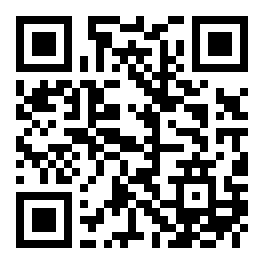

In [13]:
# Workaround to get the public URL from stdout
original_stdout = sys.stdout

output = io.StringIO()
sys.stdout = output # set print to output variable

app.launch(share=True, show_api=False, inline=False, favicon_path='/content/favicon.png')

sys.stdout = original_stdout # reset print to stdout

captured_output = output.getvalue()

link_pattern = r'(https://.*\.gradio\.live)'
re_match = re.search(link_pattern, captured_output)

if re_match:
    public_url = re_match.group(1)
    print(f"Public URL (click to open the app): {public_url}\n")
    qr_image_path = generate_qr_code(public_url)
    display(Image(qr_image_path))
else:
    exit("No URL found in the captured output.")